In [1]:
from carbon.helpers.stdimports import *
#from carbon.helpers.pdread import *
from carbon.helpers import j, strategy, pdread, pdcols, Params, fsave, listdir
from carbon.helpers.widgets import CheckboxManager, DropdownManager, PcSliderManager
from carbon.helpers.simulation import run_sim, plot_sim, SIM_DEFAULT_PARAMS

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = [12,6]
print_version(require="2.2.3")

[stdimports] imported np, pd, plt, os, sqrt, exp, log
Carbon v2.3-BETA0 (23/Jan/2022)
CarbonSimulatorUI v2.4 (12/Jan/2023)
CarbonOrderUI v1.6.1 (21/Jan/2023)


# Carbon Simulation - Demo 7-4 (frozen data; widgets)

## Setup

### Type and destination of generated output

If `OUTPATH` is `None`, output will not be saved, otherwise it will be saved to the indicated directory (use `"."` for current)

In [2]:
try:
    outpath_w()
except:
    outpath_w = DropdownManager({
        "."                        : "Current" ,
        "/Users/skl/Desktop/sim7-4": "SKL Desktop/sim7-4",},
        descr="Target", defaultix=1)
    outpath_w()

Dropdown(description='Target', index=1, options=(('Current', '.'), ('SKL Desktop/sim7-4', '/Users/skl/Desktop/…

In [3]:
try:
    output_w()
except:
    output_w = CheckboxManager.from_idvdct(
        {f"Save output to target directory": True,
         f"Show target directory listing": True,
         f"Generate docx from all charts": False,
        })
    output_w()

### The source data collection (filename)
filename determines collection, eg `RAN-050-00` is sig=50% vol and mu=0% drift; see available collections in dropdown

In [4]:
DATAPATH = "../data"
try:
    datafn_w()
except:
    datafn_w = DropdownManager(listdir(DATAPATH, ".pickle"), defaultval="RAN-050-00")
    datafn_w()

Dropdown(index=3, options=(('RAN-005-00', 'RAN-005-00'), ('RAN-010-00', 'RAN-010-00'), ('RAN-020-00', 'RAN-020…

### The data columns within that data collection (scenarios)

Withing the collection there are multiple columns (up to 1000!). With the check boxes, you can choose from a specific subset of those colums. You can specify this subset setting `COL0` and `NCOLS`. The first `NCCOLS` are checked.

In [5]:
cols = tuple(pdcols(j(DATAPATH, f"{datafn_w.value}.pickle")))
try:
    datacols_w(vertical=False)
except:
    COL0, NCOLS, NCCOLS = 0, 20, 2
    datacols_w = CheckboxManager(cols[COL0:COL0+NCOLS], values=NCCOLS*[True]+(NCOLS-NCCOLS)*[False])
    datacols_w(vertical=False)

### Strategies

This is the list of strategies to be tested against the paths. The first strategy is driven by the sliders below. The other strategies are hard-coded in the dict. The strategies `m1`, `m2` are strategy portfolios.

In [6]:
try:
    strats_w(vertical=False)
except:
    strats = {
         "slider":  None,
         "s1":      strategy.from_mgw(m=100, g=0.01, w=0.02, amt_rsk=1, amt_csh=0),
         "m1":     [strategy.from_mgw(m=100, g=0.25, w=0.05, amt_rsk=1, amt_csh=0),
                    strategy.from_mgw(m=100, g=0.10, w=0.03, amt_rsk=1, amt_csh=0)],  
         "m2":     [strategy.from_mgw(m=100, g=0.10, w=0.1,  amt_rsk=1, amt_csh=0),
                    strategy.from_mgw(m=100, g=0.20, w=0.1,  amt_rsk=1, amt_csh=0)],  
         "s3":      strategy.from_mgw(m=100, g=0.20, w=0.05, amt_rsk=1, amt_csh=0),
         "s4":      strategy.from_mgw(m=100, g=0.10, w=0.20, amt_rsk=1, amt_csh=0),
         "s5":      strategy.from_mgw(m=100, g=0.20, w=0.20, amt_rsk=1, amt_csh=0),
    }
    strats_w = CheckboxManager(strats.keys(), values=[1,0,1,0,0,0,0])
    strats_w(vertical=False)

The checkboxes above determined which strategies are tested, one by one.

### Elements to show on the chart

In [7]:
try: 
    params_w(vertical=False)
except:
    params_w = CheckboxManager.from_idvdct(SIM_DEFAULT_PARAMS.params)
    params_w(vertical=False)

### Time period

this is the time period that is plotted; periods and start dates are quoted as percentage total time; the window is cut at the left, eg start=0.9 and length=0.5 shows 0.9...1.0

In [8]:
try:
    segment_w(vertical=True)
except:
    segment_w = PcSliderManager(["Start date %", "Length %"], values=[0,1])
    segment_w(vertical=True)

In [9]:
segment_w.values

(0.0, 1.0)

### The `slider` strategy

This is the strategy called `slider`. Here `m` is the mid price of the range (adjust `S0`, `SMIN`, `SMAX` to change), `g%` is the gap between the ranges in percent, and `w%` is the width of the ranges in percent. 

In [10]:
try:
    strat1_w(vertical=True)
except:
    S0, SMIN, SMAX = 100, 50, 150
    strat1_w = PcSliderManager(["m", "g%", "w%"], values=[S0/100,0.05,0.05], range=[(SMIN/100,SMAX/100),(0,0.25),(0,0.25)])
    strat1_w(vertical=True)

In [11]:
strat1_w.values

(1.0, 0.05, 0.05)

## Simulation

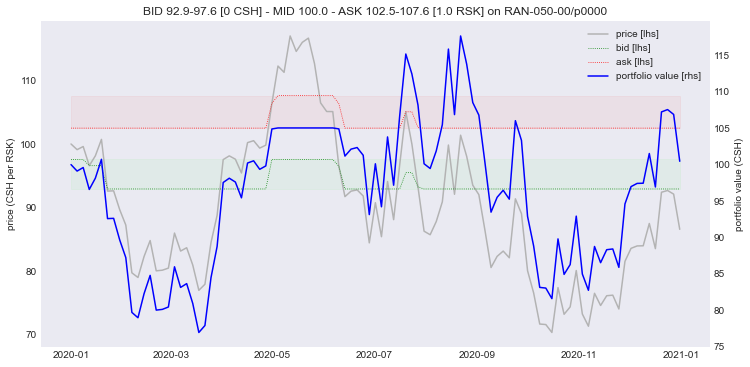

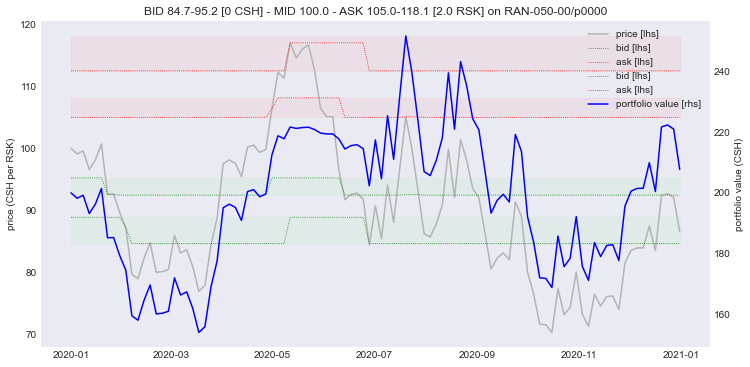

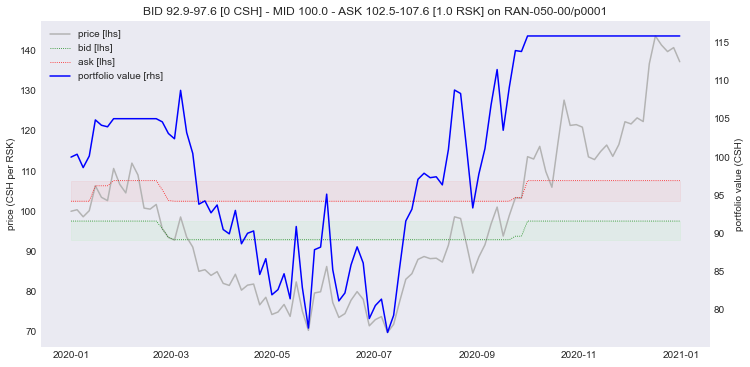

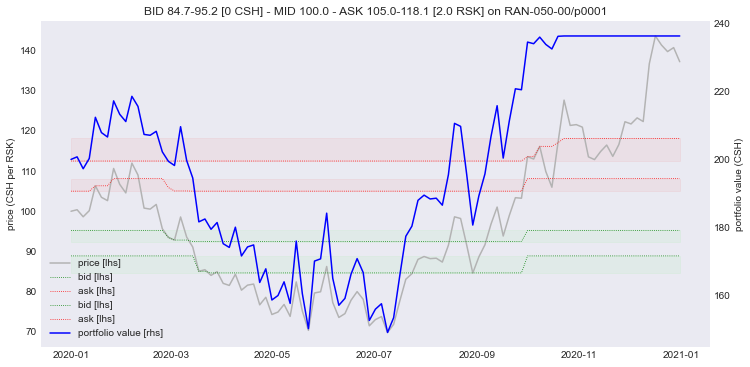

In [12]:
DATAID, DATAFN = datafn_w.value, j(DATAPATH, f"{datafn_w.value}.pickle") 
OUTPATH = outpath_w.value if output_w.values[0] else None
STARTPC, LENPC, MGW = segment_w.values[0], segment_w.values[1], strat1_w.values
strats["slider"] = strategy.from_mgw(m=100*MGW[0], g=MGW[1], w=MGW[2], amt_rsk=1, amt_csh=0.001)
for colnm in datacols_w.checked:
    for ix, stratid in enumerate(strats_w.checked):
        strat = strats[stratid]
        path = pdread(DATAFN, colnm, from_pc=STARTPC, period_pc=LENPC)
        simresults = run_sim(strat, path)
        plot_sim(strat, path, simresults, f"{DATAID}/{colnm}", Params(**params_w.values_dct))
        if isinstance(OUTPATH, str):
            plt.savefig(j(OUTPATH, f"{DATAID}-{colnm}-{ix}-{STARTPC*100:.0f}-{LENPC*100:.0f}.png"))
        plt.show()

In [13]:
#!rm {OUTPATH}/*.png # uncomment to delete all png in the output directory WITHOUT WARNING

In [14]:
if OUTPATH and output_w.values[1]:
    print("Listing OUTPATH [uncheck box at top to disable]")
    print ([fn[:-4] for fn in os.listdir(OUTPATH) if fn[-4:]==".png"])

Listing OUTPATH [uncheck box at top to disable]
['RAN-050-00-p0004-1-0-100', 'RAN-050-00-p0002-0-0-100', 'RAN-050-00-p0001-1-0-100', 'RAN-050-00-p0004-0-0-100', 'RAN-050-00-p0002-1-0-100', 'RAN-050-00-p0001-0-0-100', 'RAN-050-00-p0000-1-0-100', 'RAN-050-00-p0003-0-0-100', 'RAN-050-00-p0000-0-0-100', 'RAN-050-00-p0003-1-0-100']


In [15]:
if OUTPATH and output_w.values[2]:
    print("Creating consolidated docx from charts [uncheck box at top to disable]")
    filelist = os.listdir(OUTPATH)
    filelist = [fn for fn in filelist if fn[-4:]==".png"]
    markdown = "\n\n".join(f"![]({OUTPATH}/{fn})" for fn in filelist)
    fsave(markdown, "_sim-charts.md", OUTPATH)
    !pandoc {OUTPATH}/_sim-charts.md -o {OUTPATH}/_sim-charts.docx